Processing the Dataset

In [ ]:
!pip install wordcloud

In [28]:
#Imports & paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Paths
cleaned_csv_path = r"D:\PROJECTS\Naukri_Job_Trends\data\cleaned\naukri_cleaned.csv"
processed_csv_path = r"D:\PROJECTS\Naukri_Job_Trends\data\processed\naukri_processed.csv"


In [50]:
#Load cleaned CSV & overview
df = pd.read_csv(cleaned_csv_path)

print("Rows, Columns:", df.shape)
print("\nMissing values per column:")
display(df.isna().sum())

Rows, Columns: (1172, 16)

Missing values per column:


role                    0
job_title               0
company                 1
location                8
experience             11
salary               1028
skills                  6
posted_date             1
exp_min                11
exp_max                11
exp_avg                11
min_sal              1034
max_sal              1034
sal_avg_lpa          1034
skills_list             0
skills_normalized       6
dtype: int64

In [30]:
# Fill missing categorical columns
df['location'] = df['location'].fillna("Unknown")
df['company'] = df['company'].fillna("Unknown")
df['skills_normalized'] = df['skills_normalized'].fillna("None")

In [31]:
#Fill missing numeric/experience columns (role-wise)
exp_cols = ['exp_min', 'exp_max', 'exp_avg']
for col in exp_cols:
    df[col] = df.groupby('role')[col].transform(lambda x: x.fillna(x.mean()))


In [32]:
#Impute missing salaries (role-wise)
job_col = "role"

# Compute role-wise averages for min & max salary
role_salary_stats = df.groupby(job_col).agg(
    avg_min_sal=("min_sal", "mean"),
    avg_max_sal=("max_sal", "mean")
).round(1)

# Impute missing values using role-wise averages
def fill_salary(row):
    if pd.isna(row["min_sal"]):
        row["min_sal"] = role_salary_stats.loc[row[job_col], "avg_min_sal"]
    if pd.isna(row["max_sal"]):
        row["max_sal"] = role_salary_stats.loc[row[job_col], "avg_max_sal"]
    return row

df = df.apply(fill_salary, axis=1)

# Recompute average salary after imputation
df["sal_avg_lpa"] = df[["min_sal", "max_sal"]].mean(axis=1).round(1)


In [33]:
# Drop unnecessary / redundant columns
cols_to_drop = ["experience", "salary", "skills", "posted_date"]
df = df.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
print("Remaining columns:", df.columns.tolist())


Dropped columns: ['experience', 'salary', 'skills', 'posted_date']
Remaining columns: ['role', 'job_title', 'company', 'location', 'exp_min', 'exp_max', 'exp_avg', 'min_sal', 'max_sal', 'sal_avg_lpa', 'skills_list', 'skills_normalized']


In [ ]:
#Save processed CSV
output_csv_path = "D:/PROJECTS/Naukri_Job_Trends/data/processed/final_naukri_processed.csv"

df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")

print("Saved final processed CSV to:", output_csv_path)

Saved final processed CSV to: D:/PROJECTS/Naukri_Job_Trends/data/final_naukri_processed.csv


In [35]:
#Load processed dataset
df = pd.read_csv(output_csv_path)


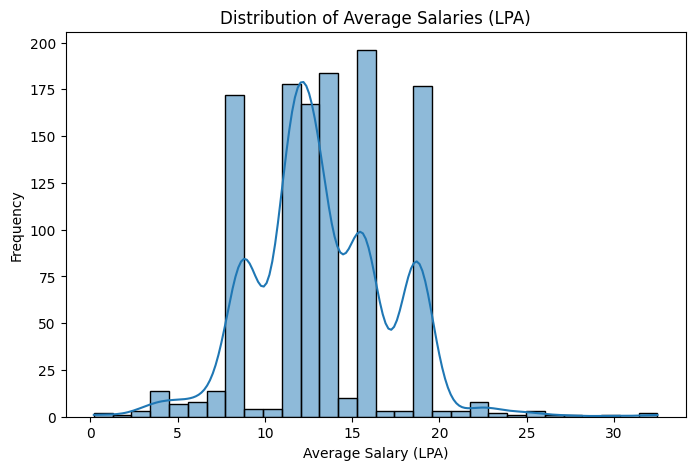

In [49]:
#Visualize Distribution of Average Salaries (LPA)
plt.figure(figsize=(8,5))
sns.histplot(df["sal_avg_lpa"], bins=30, kde=True)
plt.title("Distribution of Average Salaries (LPA)")
plt.xlabel("Average Salary (LPA)")
plt.ylabel("Frequency")
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2080\3354655765.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salary_role.values, y=salary_role.index, palette="viridis")


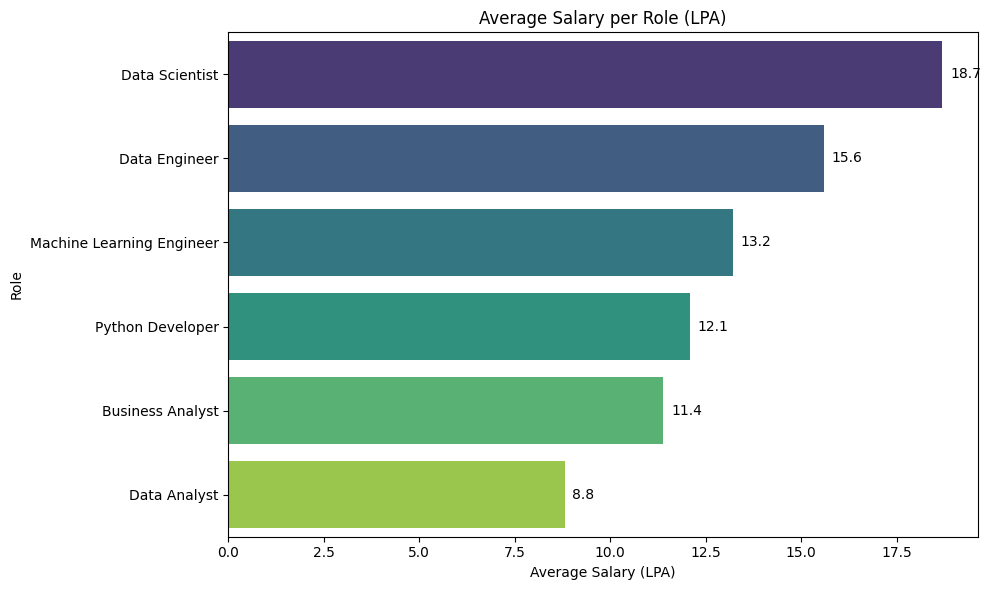

In [47]:
#Average Salary per Role (Bar Plot)
salary_role = df.groupby("role")["sal_avg_lpa"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=salary_role.values, y=salary_role.index, palette="viridis")
plt.title("Average Salary per Role (LPA)")
plt.xlabel("Average Salary (LPA)")
plt.ylabel("Role")

# Add labels
for index, value in enumerate(salary_role.values):
    plt.text(value + 0.2, index, f"{value:.1f}", va='center')

plt.tight_layout()
plt.show()


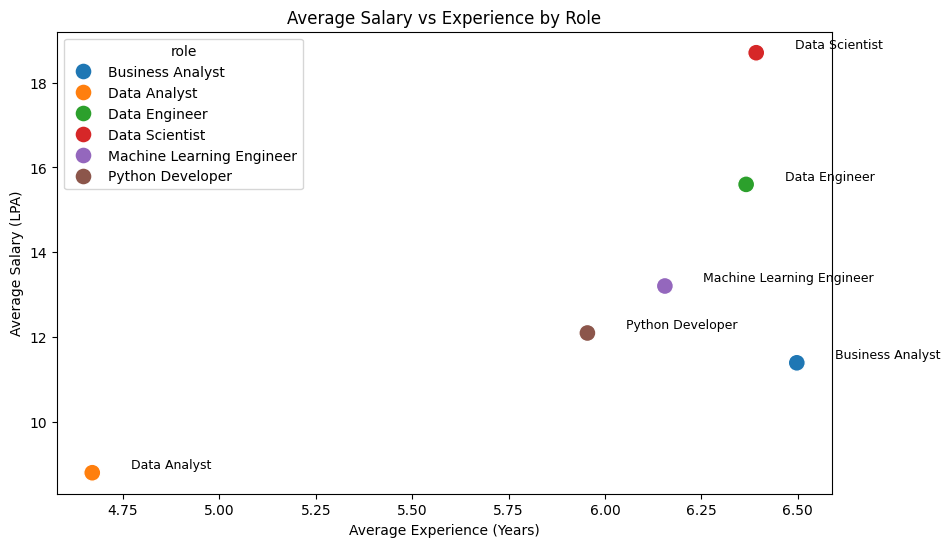

In [38]:
#Scatter Plot: Average Salary vs Experience by Role
role_exp_salary = df.groupby("role")[["exp_avg", "sal_avg_lpa"]].mean().reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=role_exp_salary, 
    x="exp_avg", 
    y="sal_avg_lpa", 
    hue="role", 
    s=150,  # bigger points
    palette="tab10"
)

for i, row in role_exp_salary.iterrows():
    plt.text(row["exp_avg"]+0.1, row["sal_avg_lpa"]+0.1, row["role"], fontsize=9)

plt.title("Average Salary vs Experience by Role")
plt.xlabel("Average Experience (Years)")
plt.ylabel("Average Salary (LPA)")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_2080\1827256959.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="role", y="sal_avg_lpa", palette="Set2")


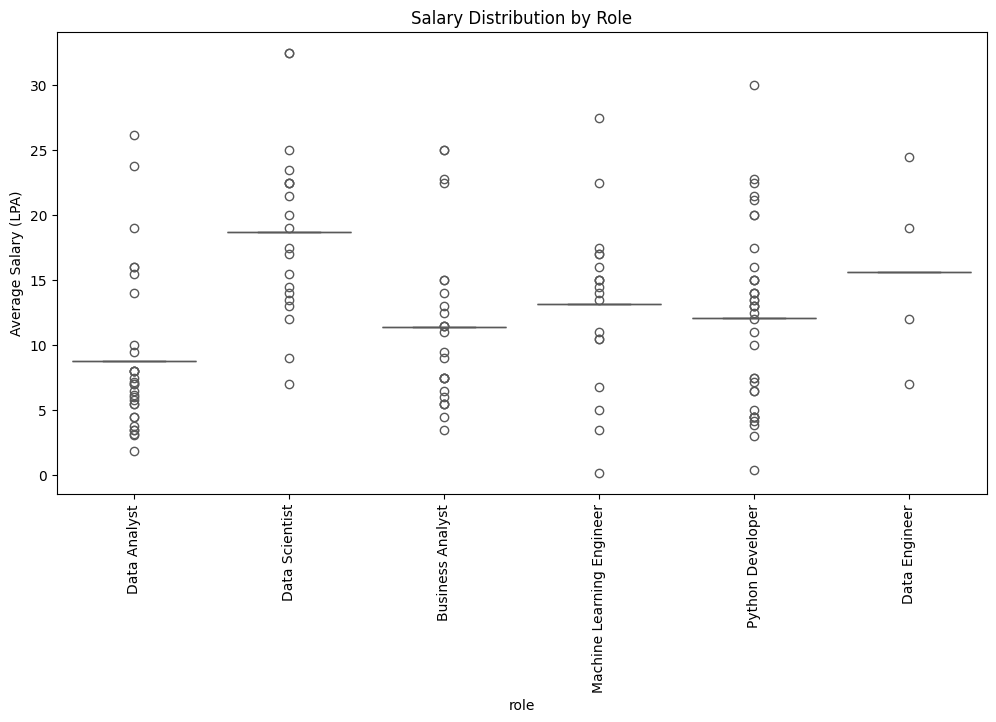

In [39]:
# Box Plot: Salary Distribution by Role
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="role", y="sal_avg_lpa", palette="Set2")
plt.title("Salary Distribution by Role")
plt.xticks(rotation=90)
plt.ylabel("Average Salary (LPA)")
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_2080\1029209607.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.values, y=location_counts.index, palette="magma")


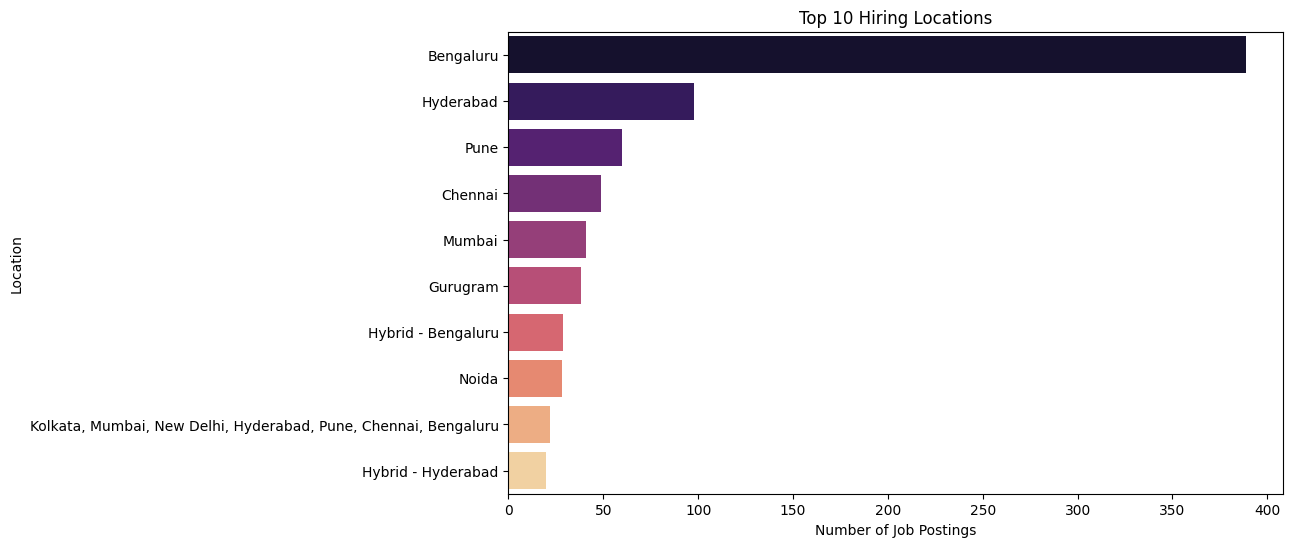

In [40]:
#Top 10 Hiring Locations
location_counts = df["location"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette="magma")
plt.title("Top 10 Hiring Locations")
plt.xlabel("Number of Job Postings")
plt.ylabel("Location")
plt.show()


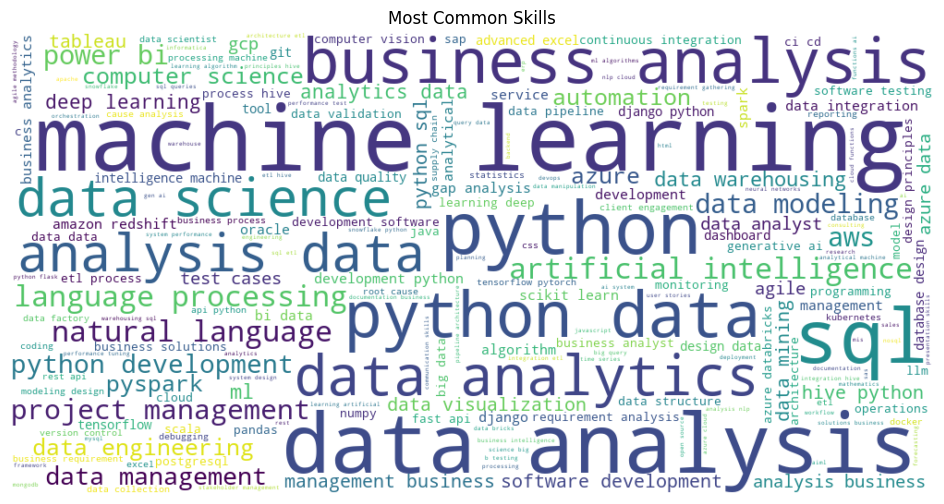

In [41]:
#Word Cloud of Most Common Skills

skills_text = " ".join(df["skills_normalized"].dropna().astype(str))
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(skills_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Skills")
plt.show()
